In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import math
from pandas_datareader import data as pdr

In [499]:
# etfs = ['XLF','XLK','XLE','XLV','XLI','XBI','XLU','XLP','XLY','KRE','XLB','XLC','XRT','XOP','XLRE','XHB','KBE','XME','KIE','XSD','XAR','XES','KCE','XNTK','XHE','XSW','XPH','XTN','XHS','XITK','XTL']
# etfs = [etf for etf in etfs if etf not in ['XLRE', 'XITK', 'XLC']]
etfs = ['XLI', 'XLF', 'XLK']
prices = yf.download(tickers=etfs, period='max')['Close']
prices

[*********************100%***********************]  3 of 3 completed


Ticker,XLF,XLI,XLK
Date,,,
1998-12-22,11.297121,14.582217,23.943209
1998-12-23,11.463700,14.836672,24.515236
1998-12-24,11.539417,15.032405,24.421837
1998-12-28,11.387995,15.110702,24.491884
1998-12-29,11.509135,15.326001,24.561922
...,...,...,...
2025-06-26,51.790001,145.339996,251.070007
2025-06-27,51.939999,146.789993,250.770004
2025-06-30,52.369999,147.520004,253.229996


In [308]:
start_dates = {}
for col in prices.columns:
    start_dates[col] = prices[col].dropna().index[0]
start_dates = pd.Series(start_dates)
start_dates.sort_values()

XLI    1998-12-22
XLY    1998-12-22
XLV    1998-12-22
XLU    1998-12-22
XLP    1998-12-22
XLK    1998-12-22
XLF    1998-12-22
XLE    1998-12-22
XLB    1998-12-22
XNTK   2000-10-02
KBE    2005-11-15
KCE    2005-11-15
KIE    2005-11-15
XSD    2006-02-06
XHB    2006-02-06
XBI    2006-02-06
KRE    2006-06-22
XRT    2006-06-22
XPH    2006-06-22
XES    2006-06-22
XOP    2006-06-22
XME    2006-06-22
XTN    2011-01-27
XTL    2011-01-27
XHE    2011-01-27
XAR    2011-09-29
XSW    2011-09-29
XHS    2011-09-29
XLRE   2015-10-08
XITK   2016-01-14
XLC    2018-06-19
dtype: datetime64[ns]

In [70]:
import industry_trends as it
import db.schemas as schemas

job = schemas.IndustryTrendsJobBase(
    initial_balance=100_000,
    start_date=pd.to_datetime('2006-01-01'),
    end_date=pd.to_datetime('2024-05-01'),
    tickers=it.etfs,
    up_period=20,
    down_period=40,
    max_leverage=200,
    target_volatility=1.5,
    rebalance_threshold=10,
    trade_cost_per_share=0.0035,
    trade_cost_min=0.35,
    benchmark='SPY',
    user='*',
)
results = it.timing_etfs(job)

<string>:165: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
<string>:165: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
<string>:165: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
<string>:165: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(c

In [109]:
#results.portfolio['AUM'].values *
a = results.portfolio.filter(like='weight_').values * results.portfolio['AUM'].values[:, np.newaxis]
pd.DataFrame(a).sum(axis=1)


Date
2006-01-03        0.00000
2006-01-04        0.00000
2006-01-05        0.00000
2006-01-06        0.00000
2006-01-09        0.00000
                 ...     
2024-04-25   177543.63497
2024-04-26   177733.88075
2024-04-29   194246.61039
2024-04-30   168515.92749
2024-05-01   144899.87031
Name: sum_exposure, Length: 4613, dtype: float64

In [110]:
np.array([[2,3,2],[5,6,1]]).copy()

array([[2, 3, 2],
       [5, 6, 1]])

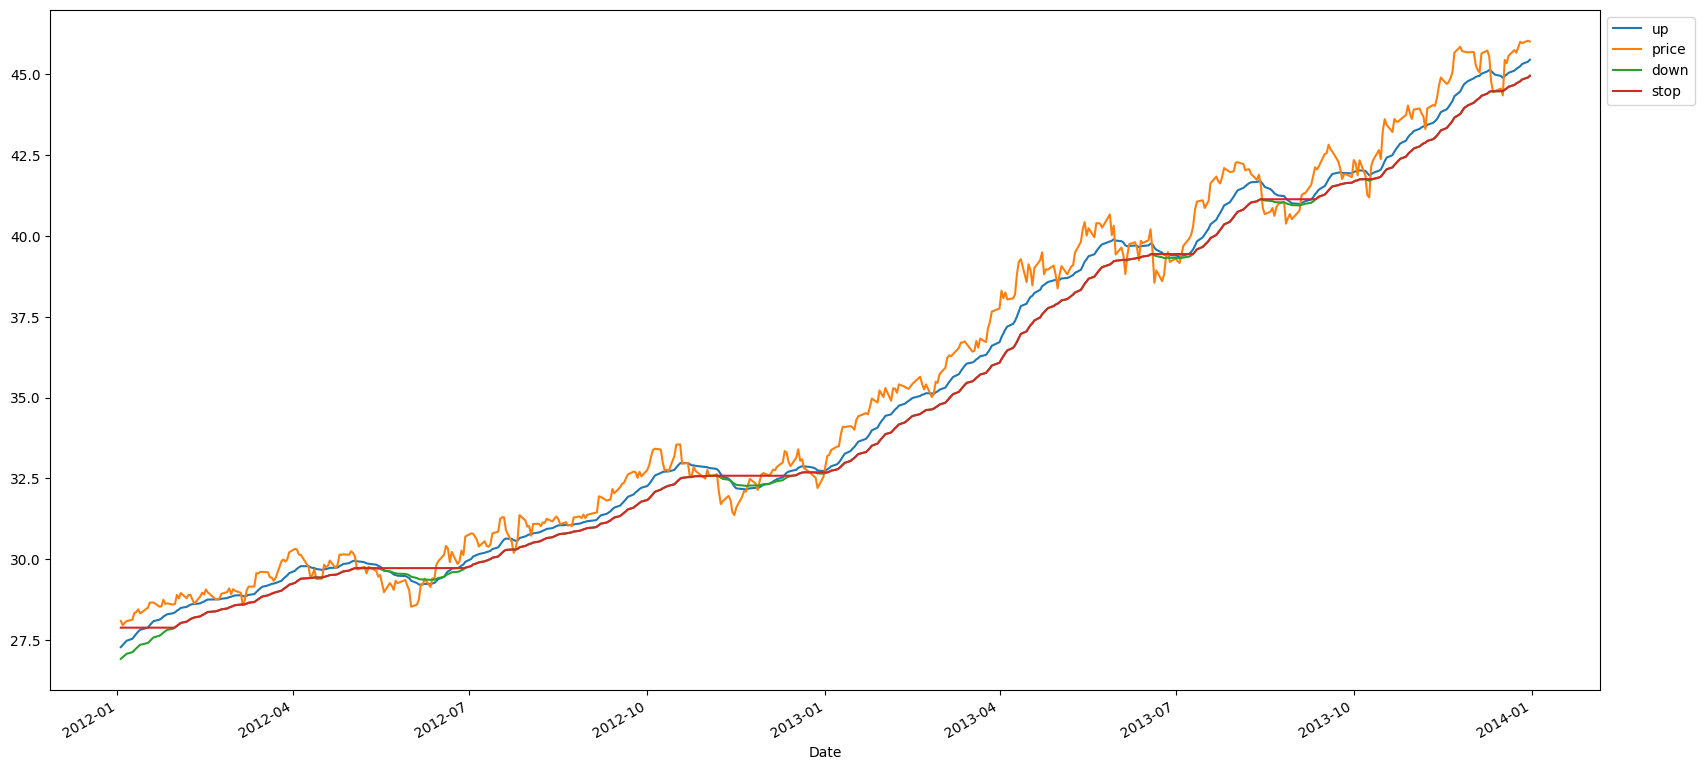

In [183]:
results.channels['XLV'].loc['2012-01-01':'2014-01-01'].dropna().plot(figsize=(20, 10)).legend(bbox_to_anchor=(1.0, 1.0))

In [48]:
pd.DataFrame(port['aum'].groupby(pd.Grouper(freq='ME')).nth(-1).pct_change() * 100).rename(
    columns={0: 'Return'})

,aum
Date,
2006-01-31,NaN
2006-02-28,0.342555
2006-03-31,-0.599842
2006-04-28,2.375893
2006-05-31,-3.400220
...,...
2024-01-31,-2.023520
2024-02-29,4.986269
2024-03-28,6.148170


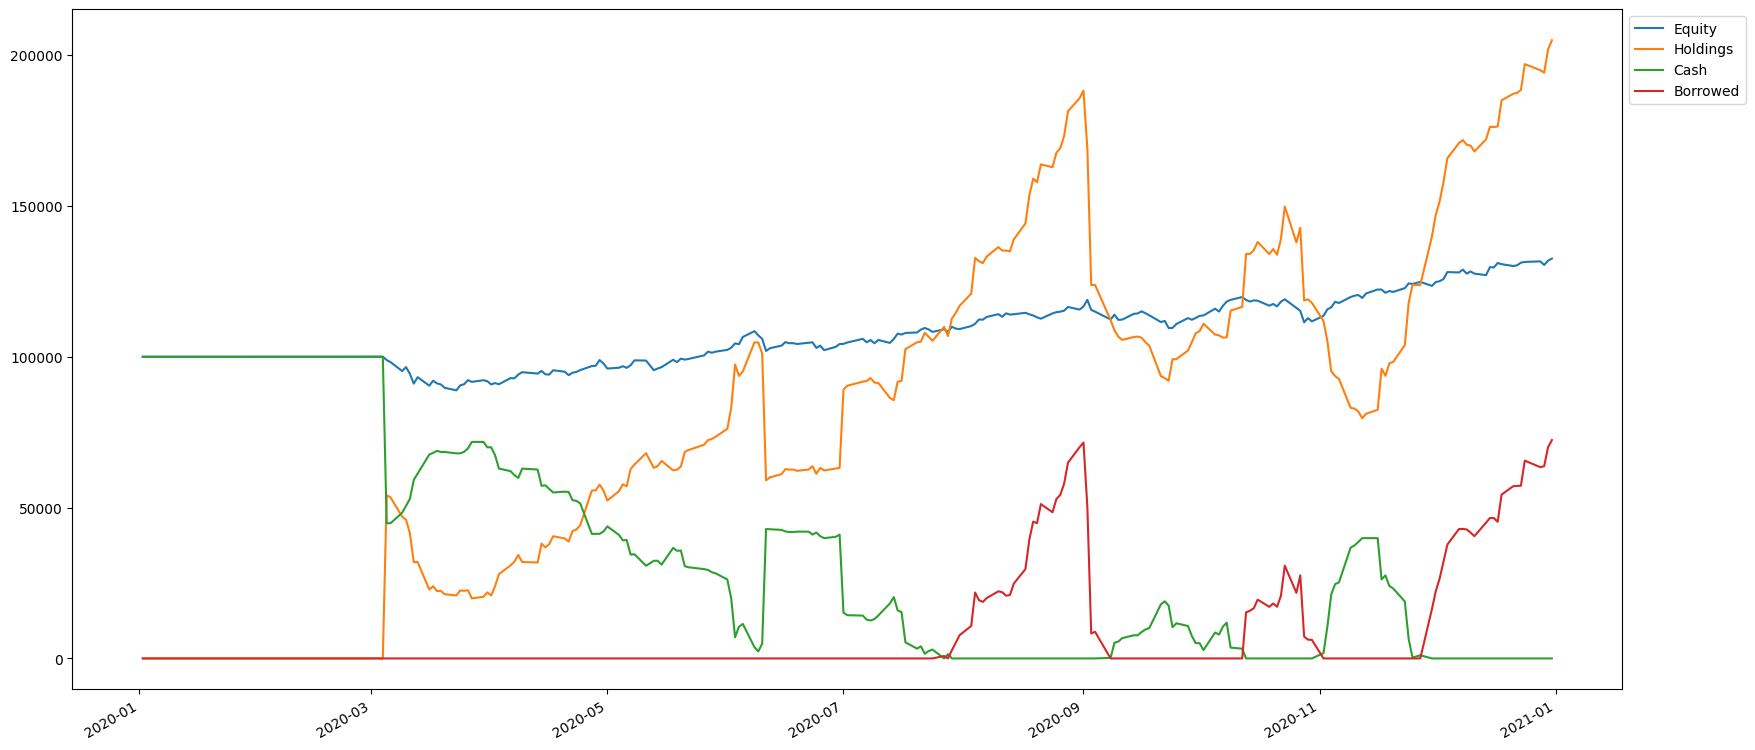

In [538]:
pd.concat([results.equity, results.holdings, results.cash, results.borrowed], axis=1).rename(
    columns={0: 'Equity', 1: 'Holdings', 2: 'Cash', 3: 'Borrowed'}
).plot(figsize=(20, 10)).legend(bbox_to_anchor=(1.0, 1.0))

In [548]:
results.shares.diff().fillna(0).astype(bool).sum().sum()

,KBE,KCE,KIE,KRE,XAR,XBI,XES,XHB,XHE,XHS,...,XLY,XME,XNTK,XOP,XPH,XRT,XSD,XSW,XTL,XTN
2020-01-02,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-06,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-07,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-08,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.0,17.319527,0.000000,0.0,5.136278,0.000000,15.780682,0.0,0.0,0.000000,...,0.0,17.248737,0.000000,7.526353,0.0,0.0,0.000000,0.000000,0.000000,16.745552
2020-12-28,0.0,0.000000,49.383883,0.0,0.000000,-4.197452,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,4.639326,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2020-12-29,0.0,-16.579864,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,8.501727,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,-11.487134,0.000000
2020-12-30,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,14.045390,0.000000,0.0,0.0,4.808081,0.000000,9.181509,0.000000


In [477]:
equity.groupby(pd.Grouper(freq='ME')).nth(-1).pct_change() * 100

2005-01-31          NaN
2005-02-28     0.000000
2005-03-31    -5.791343
2005-04-29    -4.049173
2005-05-31     7.902956
                ...    
2023-12-29    10.375402
2024-01-31     1.688451
2024-02-29     8.824674
2024-03-28     7.564722
2024-04-01    -0.815313
Length: 232, dtype: float64

In [ ]:
type(results.balance)

In [9]:
from industry_trends import TrendFollowingResults, get_tbills, etfs
import db.schemas as schemas
from datetime import datetime, timedelta
import utils
import pandas as pd
import numpy as np
import math

atr_approx_factor = 1.4
keltner_mult = 2


def trend_following_strategy(job: schemas.IndustryTrendsJobBase) -> TrendFollowingResults:
    max_leverage = job.max_leverage / 100
    target_volatility = job.target_volatility / 100
    rebalance_threshold = job.rebalance_threshold / 100

    preparation_days = math.ceil(max(job.up_period, job.down_period, job.vol_window) * 8 / 5)
    start_date = job.start_date - timedelta(days=preparation_days)

    price_dfs = []
    for ticker in job.tickers:
        price_dfs.append(utils.get_closing_prices(ticker))
    prices = pd.concat(price_dfs, axis='columns')
    prices = prices[start_date : job.end_date]

    cash = pd.Series(index=prices.index, data=0.0)
    borrowed = pd.Series(index=prices.index, data=0.0).to_dict()
    tx_costs = pd.Series(index=prices.index, data=0.0).to_dict()

    tbills_daily_rate = get_tbills()

    returns = prices.pct_change()
    volatility = returns.rolling(job.vol_window).std(ddof=0)
    weights = pd.DataFrame(index=prices.index, columns=prices.columns, data=0.0).to_dict(orient='index')
    positions = pd.DataFrame(index=prices.index, columns=prices.columns, data=False).to_dict(orient='index')
    shares = pd.DataFrame(index=prices.index, columns=prices.columns, data=0.0).to_dict(orient='index')
    signals = pd.DataFrame(index=prices.index, columns=prices.columns, data=None).to_dict(orient='index')

    ema_up = prices.ewm(span=job.up_period, adjust=False).mean()
    ema_down = prices.ewm(span=job.down_period, adjust=False).mean()
    price_change = prices.diff(periods=1).abs()
    atr_approx_up = atr_approx_factor * price_change.rolling(job.up_period, min_periods=job.up_period - 1).mean()
    atr_approx_down = atr_approx_factor * price_change.rolling(job.down_period, min_periods=job.down_period - 1).mean()

    keltner_up = ema_up + keltner_mult * atr_approx_up
    keltner_down = ema_down - keltner_mult * atr_approx_down
    donchian_up = prices.rolling(job.up_period).max()
    donchian_down = prices.rolling(job.down_period).min()

    long_band = np.minimum(donchian_up, keltner_up)
    short_band = np.maximum(donchian_down, keltner_down)

    long_band_shifted = long_band.shift(1)
    short_band_shifted = short_band.shift(1)
    long_signals = (prices >= long_band_shifted) & (long_band_shifted > short_band_shifted)

    trailing_stop = [short_band.iloc[0].fillna(0)]
    for t in range(1, len(short_band.index)):
        trailing_stop_t = np.maximum(trailing_stop[t - 1], short_band.iloc[t].fillna(0))
        trailing_stop.append(trailing_stop_t)
    trailing_stop = pd.DataFrame(index=short_band.index, columns=short_band.columns, data=trailing_stop)

    cash.iloc[:preparation_days] = job.initial_balance

    # EOD: prices, channels, bands, trailing stops. These are computed for the end of the day, because they are derived from close prices.
    # SOD: positions, weights. These are computed for the start of the day. We use t - 1 EOD data to get t SOD positions and weights.
    # This means that at the end of day t - 1 we figure out what trades we need to execute the following morning. After the trades are executed
    # positions and weights for day t become reality. At the end of the t day, when evaluating the portfolio, we use the t positions and weights.

    for t in range(preparation_days, len(prices)):
        date = prices.index[t]
        # print(f'* Day {t} - {date}')
        prev_date = prices.index[t - 1]

        # Compute desired positions at the end of the day
        for j in prices.columns:
            prev_position = positions[prev_date][j]
            prev_price = prices[j].iloc[t - 1]

            # Entry condition
            if not prev_position and long_signals[j].iloc[t]:
                positions[date][j] = True
                print(f'Entry {j} {date}')
            # Exit condition
            elif prev_position:
                if prev_price <= trailing_stop[j].iloc[t]:
                    print(f'Exit {j} {date}')
                    positions[date][j] = False
                else:
                    positions[date][j] = True
            else:
                positions[date][j] = False

        # Compute desired weights at the start of the day
        active = positions[date]
        n_active = sum(active.values())
        weights_today = {}
        for j in prices.columns:
            if active[j]:
                sigma = volatility[j].iloc[t]
                if pd.notna(sigma) and sigma > 0:
                    w = (target_volatility / n_active) / sigma
                    weights_today[j] = w
                else:
                    weights_today[j] = 0
            else:
                weights_today[j] = 0
        exposure = sum(weights_today.values())
        if exposure > max_leverage:
            scaling_factor = max_leverage / exposure
            for j in weights_today:
                weights_today[j] *= scaling_factor
        weights[date] = weights_today

        # Evaluate portfolio and compute real weights before rebalancing
        holdings = prices.loc[prev_date] * pd.Series(shares[prev_date])
        borrowed[date] = borrowed[prev_date] + borrowed[prev_date] * tbills_daily_rate.loc[prev_date]
        cash[date] = cash[prev_date] + cash[prev_date] * tbills_daily_rate.loc[prev_date]
        equity = holdings.fillna(0).sum() + cash[date] - borrowed[date]
        before_rebalance_weights = holdings / equity

        trade_balance = 0
        for j in prices.columns:
            if weights_today[j] > before_rebalance_weights[j]:
                # We buy
                amount = (weights_today[j] - before_rebalance_weights[j]) * equity
                bought_shares = amount / prices.loc[prev_date, j]
                pct_change_shares = bought_shares / shares[prev_date][j] if shares[prev_date][j] > 0 else +math.inf
                if pct_change_shares >= rebalance_threshold:
                    shares[date][j] = shares[prev_date][j] + bought_shares
                    fees = max(job.trade_cost_min, job.trade_cost_per_share * bought_shares)
                    tx_costs[date] += fees
                    trade_balance += -fees - amount
                    # print(f'  Buying {bought_shares} shares of {j} for ${amount} (${prices.loc[prev_date, j]}/share) - change {pct_change_shares * 100} % (W: {before_rebalance_weights[j] * 100}% -> {weights_today[j] * 100}%)')
                else:
                    shares[date][j] = shares[prev_date][j]
            elif weights_today[j] < before_rebalance_weights[j]:
                # We sell
                amount = (before_rebalance_weights[j] - weights_today[j]) * equity
                sold_shares = amount / prices.loc[prev_date, j]
                pct_change_shares = sold_shares / shares[prev_date][j] if shares[prev_date][j] > 0 else +math.inf
                if pct_change_shares >= rebalance_threshold:
                    shares[date][j] = shares[prev_date][j] - sold_shares
                    fees = max(job.trade_cost_min, job.trade_cost_per_share * sold_shares)
                    tx_costs[date] += fees
                    trade_balance += -fees + amount
                    # print(f'  Selling {sold_shares} shares of {j} for ${amount} (${prices.loc[prev_date, j]}/share) - change {pct_change_shares * 100} % (W: {before_rebalance_weights[j] * 100}% -> {weights_today[j] * 100}%)')
                else:
                    shares[date][j] = shares[prev_date][j]
            else:
                shares[date][j] = shares[prev_date][j]
        if trade_balance >= 0:
            cash[date] += max(0, trade_balance - borrowed[date])
            borrowed[date] = max(0, borrowed[date] - trade_balance)
        else:
            borrowed[date] += max(0, -trade_balance - cash[date])
            cash[date] = max(0, cash[date] + trade_balance)
        # equity = (prices.loc[date] * pd.Series(shares[date])).fillna(0).sum() + cash[date] - borrowed[date]
        # print(f'- Cash: {cash[date]} | Borrowed: {borrowed[date]} | Holdings: {(prices.loc[date] * pd.Series(shares[date])).fillna(0).sum()} | Equity: {equity} | Exposure: {sum(weights_today.values())} | Leverage: {(equity + borrowed[date]) / equity}')
    weights = pd.DataFrame.from_dict(weights, orient='index')
    positions = pd.DataFrame.from_dict(positions, orient='index')
    shares = pd.DataFrame.from_dict(shares, orient='index')
    cash = pd.Series(cash)
    borrowed = pd.Series(borrowed)
    tx_costs = pd.Series(tx_costs)

    holdings = (shares * prices).fillna(0).sum(axis=1)
    equity = holdings + cash - borrowed

    benchmark_prices = utils.get_closing_prices(job.benchmark)[start_date : job.end_date]
    benchmark_balance = (benchmark_prices.pct_change() + 1).fillna(1).cumprod() * job.initial_balance
    balance = pd.concat([equity, holdings, cash, borrowed, benchmark_balance], axis=1).rename(
        columns={0: 'Equity', 1: 'Holdings', 2: 'Cash', 3: 'Borrowed'}
    )
    balance.index.name = 'Date'

    benchmark_returns = pd.DataFrame(benchmark_prices.groupby(pd.Grouper(freq='ME')).nth(-1).pct_change() * 100).rename(
        columns={job.benchmark: 'Return'}
    )
    benchmark_returns.index.name = 'Date'
    benchmark_returns['Year'] = benchmark_returns.index.year
    benchmark_returns['Month'] = benchmark_returns.index.month
    benchmark_returns = benchmark_returns.pivot(index='Year', columns='Month', values='Return')
    benchmark_returns = ((1 + benchmark_returns / 100).prod(axis=1) - 1) * 100

    monthly_returns = pd.DataFrame(equity.groupby(pd.Grouper(freq='ME')).nth(-1).pct_change() * 100).rename(
        columns={0: 'Return'}
    )
    monthly_returns.index.name = 'Date'
    monthly_returns['Year'] = monthly_returns.index.year
    monthly_returns['Month'] = monthly_returns.index.month
    monthly_returns = monthly_returns.pivot(index='Year', columns='Month', values='Return')
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    if len(monthly_returns.columns) < 12:
        kept_months = []
        for i in range(0, 12):
            if i in monthly_returns.columns:
                kept_months.append(month_names[i])
        monthly_returns.columns = kept_months
    else:
        monthly_returns.columns = month_names
    monthly_returns['Yearly'] = ((1 + monthly_returns / 100).prod(axis=1) - 1) * 100
    monthly_returns[f'Benchmark ({job.benchmark})'] = benchmark_returns

    trades = shares.diff().fillna(0)
    trades = trades.loc[~(trades == 0).all(axis=1)]
    trades = trades.astype(str)
    trades.index.name = 'Date'

    drawdowns = pd.DataFrame()

    def compute_drawdown(col: str):
        running_max = balance[col].cummax()
        drawdown_pct = (balance[col] - running_max) / running_max * 100
        mdd = drawdown_pct.min()
        return f'{round(mdd, 2)}%'

    drawdowns['Max Strategy Drawdown'] = [compute_drawdown('Equity')]
    drawdowns[f'Max {job.benchmark} Drawdown'] = [compute_drawdown(job.benchmark)]

    return TrendFollowingResults(
        weights=weights[job.start_date :],
        positions=positions[job.start_date :],
        trailing_stop=trailing_stop[job.start_date :],
        cash=cash[job.start_date :],
        borrowed=borrowed[job.start_date :],
        shares=shares[job.start_date :],
        holdings=holdings[job.start_date :],
        equity=equity[job.start_date :],
        balance=balance[job.start_date :],
        tx_costs=tx_costs[job.start_date :],
        monthly_returns=monthly_returns,
        trades=trades[job.start_date :],
        drawdowns=drawdowns,
        signals=pd.DataFrame(),
        channels=pd.DataFrame(),
        keltner_channels=pd.DataFrame(),
        donchian_channels=pd.DataFrame(),
    )


job = schemas.IndustryTrendsJobBase(
    initial_balance=100_000,
    start_date=pd.to_datetime('2005-01-01'),
    end_date=pd.to_datetime('2024-05-01'),
    tickers=etfs,
    up_period=20,
    down_period=40,
    max_leverage=200,
    target_volatility=1.5,
    rebalance_threshold=10,
    trade_cost_per_share=0.0035,
    trade_cost_min=0.35,
    benchmark='SPY',
    user='*',
)
results = trend_following_strategy(job)

Entry XLE 2005-02-01 00:00:00
Entry XLU 2005-02-01 00:00:00
Entry XLP 2005-02-02 00:00:00
Entry XLB 2005-02-02 00:00:00
Entry XLF 2005-02-04 00:00:00
Entry XLI 2005-02-04 00:00:00
Entry XLV 2005-02-11 00:00:00
Exit XLF 2005-02-23 00:00:00
Exit XLI 2005-02-23 00:00:00
Entry XLI 2005-03-03 00:00:00
Entry XNTK 2005-03-07 00:00:00
Exit XNTK 2005-03-08 00:00:00
Exit XLP 2005-03-22 00:00:00
Exit XLI 2005-03-30 00:00:00
Exit XLB 2005-03-30 00:00:00
Entry XLP 2005-04-12 00:00:00
Exit XLE 2005-04-18 00:00:00
Exit XLP 2005-04-18 00:00:00
Entry XLF 2005-05-04 00:00:00
Exit XLF 2005-05-05 00:00:00
Entry XLK 2005-05-13 00:00:00
Entry XNTK 2005-05-13 00:00:00
Exit XLK 2005-05-16 00:00:00
Exit XNTK 2005-05-16 00:00:00
Entry XLK 2005-05-17 00:00:00
Entry XLI 2005-05-17 00:00:00
Entry XLY 2005-05-17 00:00:00
Entry XNTK 2005-05-17 00:00:00
Entry XLF 2005-05-18 00:00:00
Exit XLK 2005-05-18 00:00:00
Exit XLI 2005-05-18 00:00:00
Entry XLP 2005-05-18 00:00:00
Exit XLY 2005-05-18 00:00:00
Exit XNTK 2005-05-1

TypeError: TrendFollowingResults.__init__() got an unexpected keyword argument 'signals'

In [13]:
import kfrench
kfrench.FRENCH_DATA_FACTORS_LOCAL_PATH.parent

PosixPath('/home/smarton/Work/dm/data')